# IFT6390 Project - Data Exploration snippets

## Useful piece of code

## Setup - data

In [1]:
print(__doc__)

#!pip install keras
#!{sys.executable} -m pip install scikit-plot

import keras
import scikitplot as skplt

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import sys


#Natural Language Toolkit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#identifies words which are not adding semantic value to the sentence
stopw = set(stopwords.words('english'))

Automatically created module for IPython interactive environment


Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guillaume\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import cleaned dataframe

In [4]:
a=datetime.datetime.now()

s140=pd.read_pickle('ds_28nov/s140_clean_28nov.pkl')
mr=pd.read_pickle('ds_28nov/mr_clean_28nov.pkl')
cc=pd.read_pickle('ds_28nov/cc_clean_28nov.pkl')

print(datetime.datetime.now()-a)

0:00:07.033978


In [5]:
s140.target

0          negative
1          negative
2          negative
3          negative
4          negative
             ...   
1600493    positive
1600494    positive
1600495    positive
1600496    positive
1600497    positive
Name: target, Length: 1600498, dtype: object

In [6]:
print('NaN before replace: ', cc.target.isna().sum())
cc=cc.replace({'target': {np.nan: 'Not Sure'}})
print('NaN after replace: ', cc.target.isna().sum())

def nnlabel(df):
    return df.replace({'target': {'positive':1,'Not Sure':0,'neutral':0,'negative':2}})

cc=nnlabel(cc)
mr=nnlabel(mr)
s140=nnlabel(s140)

NaN before replace:  1840
NaN after replace:  0


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer 

def make_tfidf(df):
    tf_vect=TfidfVectorizer(use_idf=False,stop_words=stopw)
    tf=tf_vect.fit_transform(df.tolist())
    
    l=tf.shape[0]
    
    w_count=np.array(tf.sum(axis=0,))[0]/l
    #wcm=w_count.max()
    #w_count=w_count/wcm
    wcr=w_count.argsort()[::-1].argsort()

    
    idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
    idf=idf_vect.fit_transform(df.tolist())
    
    w_marker=np.array(idf.sum(axis=0))[0]/l
    #wmm=w_marker.max()
    #w_marker=w_marker/wmm
    wmr=w_marker.argsort()[::-1].argsort()
    
    
    # SRC -> https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
    feature_names=tf_vect.get_feature_names()
    
    tf_idf = pd.DataFrame(np.array([w_count, w_marker, wcr, wmr]).T, index=feature_names, columns=["tf", "idf", "rank_tf", "rank_idf"])
    tf_idf = tf_idf.sort_values(by=["tf"],ascending=False)

    tf_idf.rank_tf=tf_idf.rank_tf.astype('int64')
    tf_idf.rank_idf=tf_idf.rank_idf.astype('int64')

    return tf_idf


## Transform s140

In [8]:
#all=make_tfidf(s140['trimmed'])

In [42]:
a=datetime.datetime.now()

s140_tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
s140_tf_idf=s140_tf_idf_vect.fit_transform(s140['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:14.945347


## Transform MR

In [43]:
a=datetime.datetime.now()

mr_tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
mr_tf_idf=mr_tf_idf_vect.fit_transform(mr['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:04.948728


## Transform CC

In [70]:
a=datetime.datetime.now()

cc_tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
cc_tf_idf=cc_tf_idf_vect.fit_transform(cc['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:00.069699


## Model testing

In [109]:
#import scikitplot as skplt
#import scikitplot#.plotters as skplt

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#The mean score and the 95% confidence interval of the score estimate are hence given by:

def crossval(model, x, y):  
    scores = cross_val_score(model, x, y, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

def confusion(y_valid,predicted):
    if len(y_valid.shape)!=1 or len(predicted.shape)!=1:
        y_v=np.argmax(y_valid,axis=1)
        pred=np.argmax(predicted,axis=1)
    skplt.metrics.plot_confusion_matrix(y_v, pred,x_tick_rotation=90,figsize=(3,6), normalize=True)
    plt.show()  
    
def TryModel(model, xt, yt,xv=0,yv=0, selfie=True):  
    if selfie:
        X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    else:
        X_train, X_valid, y_train, y_valid=xt,xv,yt,yv

    clf = model.fit(X_train, y_train)

    predicted = clf.predict(X_valid)

    acc=accuracy_score(y_valid, predicted)
    print(f"Accuracy: {acc}")

    confusion(y_valid,predicted)

    return y_valid,predicted


from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

## Data
#data = np.random.random((1000,100))
#labels = np.random.randint(2,size=(1000,1))

class nn:
    def __init__(self):
        self.model = None
        self.x = None
        self.y = None
        
    def train(self, x,y,epoch=1,layers=16):
        # Define network (model)
        self.model = Sequential() 

        self.y = to_categorical(y,3)
        self.model.add(Dense(layers, activation='relu', input_dim=x.shape[1]))
        self.model.add(Dense(self.y.shape[1], activation='sigmoid'))

        # Configure training
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model by training
        self.model.fit(x,self.y,epochs=epoch,batch_size=250)
        
    def predict(self, x_test):
        # Make predictions
        return self.y,self.model.predict(x_test)
    
    def eval(self, x,y):
        test_loss, test_acc = network.evaluate(x,y)
        return test_loss, test_acc

In [24]:
#import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11564677703944379070
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6618563871
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6877460854710942424
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:29:00.0, compute capability: 7.5"
]


AttributeError: module 'tensorflow' has no attribute 'Session'

## Trained and tested on the same dataset (selfie)

### mr

Epoch 1/1
50000/50000 [==============================] - 23s 453us/step - loss: 0.7790 - accuracy: 0.6368


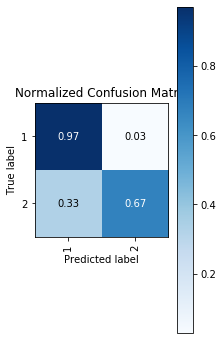

In [98]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

mrNN=nn()
mrNN.train(x, y)
mr_y,mr_pred=mrNN.predict(x)
confusion(mr_y,mr_pred)

#print(datetime.datetime.now()-a)

### cc

Epoch 1/5
6027/6027 [==============================] - 0s 57us/step - loss: 1.0780 - accuracy: 0.5178
Epoch 2/5
6027/6027 [==============================] - 0s 47us/step - loss: 1.0396 - accuracy: 0.5281
Epoch 3/5
6027/6027 [==============================] - 0s 49us/step - loss: 1.0033 - accuracy: 0.5382
Epoch 4/5
6027/6027 [==============================] - 0s 47us/step - loss: 0.9671 - accuracy: 0.5479
Epoch 5/5
6027/6027 [==============================] - 0s 49us/step - loss: 0.9320 - accuracy: 0.5567


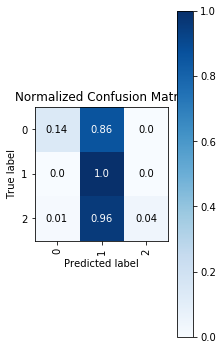

0:00:02.132393


In [99]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = cc_tf_idf, cc['target']
with tf.device('/GPU:0'):
    ccNN=nn()
    ccNN.train(x, y, 5)
    cc_y, cc_pred=ccNN.predict(x)
    confusion(cc_y,cc_pred)

    print(datetime.datetime.now()-a)

### s140

Epoch 1/1
1600498/1600498 [==============================] - 4266s 3ms/step - loss: 0.4996 - accuracy: 0.7730


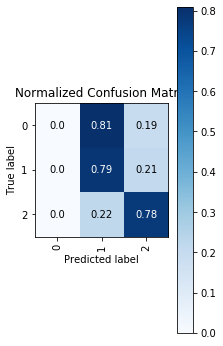

2:24:11.825133


In [110]:
a=datetime.datetime.now()

x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']
with tf.device('/GPU:0'):
    s140NN=nn()
    s140NN.train(x, y)
    s140_y,s140_pred=s140NN.predict(x)
    confusion(s140_y,s140_pred)

print(datetime.datetime.now()-a)

# Cross-Trained

## NN Movies trained w S140

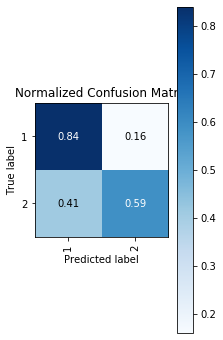

0:02:20.537636


In [111]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = s140_tf_idf_vect.transform(mr['trimmed'].tolist()), mr['target']
#x,y = cc_tf_idf, cc['target']

_,pred=s140NN.predict(x)

mronehot = np.zeros(pred.shape)
for j, i in enumerate(y):
    mronehot[j][i] = 1

confusion(mronehot,pred)

print(datetime.datetime.now()-a)

## NN CC trained w S140

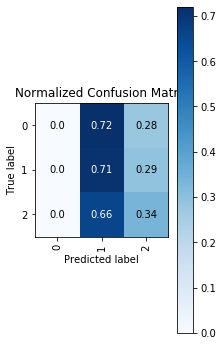

0:00:16.450140


In [112]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = s140_tf_idf_vect.transform(cc['trimmed'].tolist()), cc['target']

_,pred=s140NN.predict(x)

cconehot = np.zeros(pred.shape)
for j, i in enumerate(y):
    cconehot[j][i] = 1

confusion(cconehot,pred)

print(datetime.datetime.now()-a)

## NN Movies trained w CC

In [113]:
print(x.shape)
print(cc_tf_idf.shape)

(6027, 549424)
(6027, 8235)


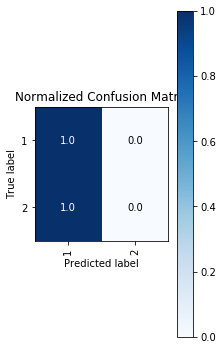

0:00:07.107153


In [114]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = cc_tf_idf_vect.transform(mr['trimmed'].tolist()), mr['target']
#x,y = cc_tf_idf, cc['target']

_, pred = ccNN.predict(x)
confusion(mronehot,pred)

print(datetime.datetime.now()-a)

## NN CC trained w Movies

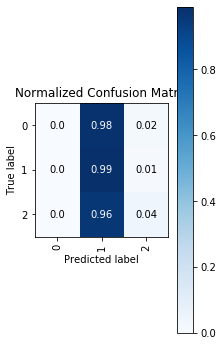

0:00:02.996207


In [115]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = mr_tf_idf_vect.transform(cc['trimmed'].tolist()), cc['target']

_,pred=mrNN.predict(x)
confusion(cconehot,pred)

print(datetime.datetime.now()-a)

## NN s140 trained w CC

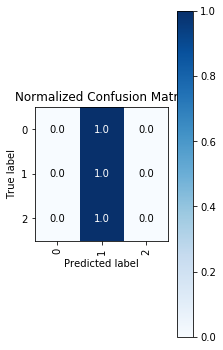

0:04:00.181404


In [116]:
a=datetime.datetime.now()

x,y = cc_tf_idf_vect.transform(s140['trimmed'].tolist()), s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

_,pred=ccNN.predict(x)

s140onehot = np.zeros(pred.shape)
for j, i in enumerate(y):
    s140onehot[j][i] = 1

confusion(s140onehot,pred)

print(datetime.datetime.now()-a)

## NN s140 trained w Movies

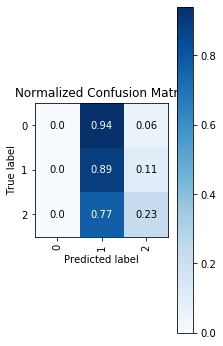

0:14:47.709653


In [117]:
a=datetime.datetime.now()

x,y = mr_tf_idf_vect.transform(s140['trimmed'].tolist()), s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

_,pred=mrNN.predict(x)
confusion(s140onehot,pred)

print(datetime.datetime.now()-a)

In [128]:
import pickle

pickling_on = open("s140NN.pkl","wb")
pickle.dump(s140NN, pickling_on)
pickle.dump(mrNN, pickling_on)
#pickling_on.close()

In [130]:
#pickling_on2 = open("mrNN.pkl","w")
pickle.dump(mrNN, pickling_on2)
pickling_on2.close()

PicklingError: Can't pickle <class '__main__.nn'>: it's not the same object as __main__.nn

In [ ]:
#pickling_on3 = open("ccNN.pkl","wb")
pickle.dump(ccNN, pickling_on3)
pickling_on3.close()

In [127]:
pickling_on.close()